In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
def display(img):
    image_width = image_height = np.ceil(np.sqrt(img.shape[0])).astype(np.uint8)
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [3]:
X_train = idx2numpy.convert_from_file("../hw1/train-images.idx3-ubyte")
X_test = idx2numpy.convert_from_file("../hw1/t10k-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file("../hw1/train-labels.idx1-ubyte")
y_test = idx2numpy.convert_from_file("../hw1/t10k-labels.idx1-ubyte")

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

labels_count = np.unique(y_train).shape[0]
y_train = dense_to_one_hot(y_train, labels_count)
y_test = dense_to_one_hot(y_test, labels_count)

In [4]:
class RBM():
    def _sigmoid(self, z):
        z = np.maximum(-15.0, z)
        z = np.minimum(15.0, z)
        return 1.0 / (1 + np.exp(-z))
    
    def cross_entropy(self, y_pred, y_true):
        eps = 1e-15
        y_pred = np.maximum(eps, y_pred)
        y_pred = np.minimum(1-eps, y_pred)
        return np.mean(-np.sum(np.log(y_pred) * y_true, axis=1))
        
        
    def gibbs_sampling(self, steps):
        pass
        
    
    def __init__(self, n_hidden, learning_rate, n_iter, gibbs_steps = 1, batch_size = 0,
                 layers = {'visible': 'bernoulli', 'hidden':  'bernoulli'}, verbose = False):
        self.n_visible = None
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.gibbs_steps = gibbs_steps
        self.verbose = verbose
        self.batch_size = batch_size
        self.visible_states = None
        self.hidden_states = None
        self.loss_history = None
        self.layers = layers
        
        
    def fit(self, X):
        self.loss_history = []
        if self.batch_size == 0:
            self.batch_size = X.shape[0] + 1
        self.n_visible = X.shape[1]
        # weights
        self.weights = np.random.normal(0, 0.01, (self.n_visible, self.n_hidden))
        # biases
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
        X = np.insert(X, 0, 1, axis = 1) # bias
        for epoch in range(self.n_iter):
            X = shuffle(X)
            X_mini_batch = X[:self.batch_size]
            for step in range(self.gibbs_steps):
                # POSITIVE CD PHASE
                pos_hidden_act = np.dot(X_mini_batch, self.weights)
                pos_hidden_prob = self._sigmoid(pos_hidden_act)
                pos_hidden_states = pos_hidden_prob > np.random.rand(self.batch_size, self.n_hidden + 1).astype(np.float32)
                self.hidden_states = pos_hidden_states

                # NEGATIVE CD PHASE
                neg_visible_act = np.dot(pos_hidden_states, self.weights.T)
                # neg_visible_act = np.dot(pos_hidden_prob, self.weights.T)
                neg_visible_prob = self._sigmoid(neg_visible_act)
                neg_visible_prob[:, 0] = 1 # bias
                neg_hidden_act = np.dot(neg_visible_prob, self.weights)
                neg_hidden_prob = self._sigmoid(neg_hidden_act)
            
            # Weights updating.
            pos_assoc = np.dot(X_mini_batch.T, pos_hidden_prob)
            neg_assoc = np.dot(neg_visible_prob.T, neg_hidden_prob)
            self.weights += self.learning_rate * ((pos_assoc - neg_assoc) / self.batch_size)
            loss = self.cross_entropy(neg_visible_prob[:, 1:], X_mini_batch[:, 1:])
            self.loss_history.append(loss)
            if self.verbose and epoch % 10 == 0:
                print "Epoch: ", epoch," loss: ", loss
            
    def run_on_visible(self, X):
        """
        given visible unit, getting a sample of hidden units
        """
        n_examples = X.shape[0]
        hidden_states = np.ones((n_examples, self.n_hidden + 1))
        X = np.insert(X, 0, 1, axis = 1) # bias
        
        hidden_acts = np.dot(X, self.weights)
        hidden_prob = self._sigmoid(hidden_acts)
        hidden_states[:,:] = hidden_prob# > np.random.rand(n_examples, self.n_hidden + 1)
        hidden_states = hidden_states[:, 1:] # without bias
        return hidden_states
    
    def run_on_hidden(self, X_hidden):
        """
        given set of hidden units, trying to get some good visible units
        """
        n_examples = X_hidden.shape[0]
        vis_states = np.ones((n_examples, self.n_visible + 1))
        X_hidden = np.insert(X_hidden, 0, 1, axis = 1) # bias
        
        visible_acts = np.dot(X, self.weights.T)
        visible_prob = self._sigmoid(visible_acts)
        visible_states[:,:] =  visible_prob > np.random.rand(n_examples, self.n_visible + 1)
        visible_states = visible_states[:, 1:] # without bias
        
        return visible_states

In [5]:
rbm_nn = RBM(n_hidden=100, learning_rate=0.25, n_iter=100, gibbs_steps = 1, batch_size = 20, verbose = True,
            layers = {'visible': 'bernoulli',
                      'hidden':  'bernoulli'})

In [6]:
rbm_nn.fit(X_train)

Epoch:  0  loss:  17006.7419308
Epoch:  10  loss:  307.482590653
Epoch:  20  loss:  16.5233624371
Epoch:  30  loss:  278.635693857
Epoch:  40  loss:  390.070370427
Epoch:  50  loss:  174.063652205
Epoch:  60  loss:  378.087125295
Epoch:  70  loss:  173.681580724
Epoch:  80  loss:  37.2000074199
Epoch:  90  loss:  0.00660813150846


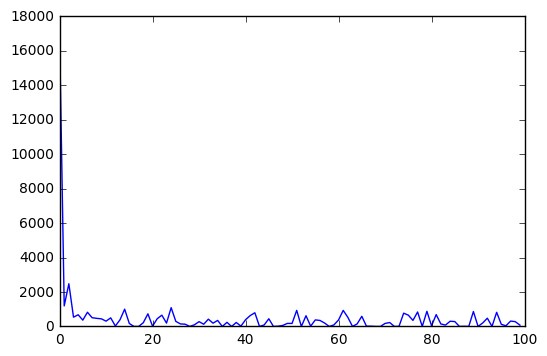

In [7]:
plt.plot(rbm_nn.loss_history)
# print "Accuracy: %.4f" % test_accuracy(np.argmax(testnn.predict(X_test), axis = 1), np.argmax(y_test, axis = 1))

In [8]:
def plot_filters(df, n, m, w=8, h=8):
    a1, a2 = float(n) / (n + m), float(m) / (n + m)
    f, axarr = plt.subplots(n, m, figsize=(2 * w * a2, 2 * h * a1))
    f.subplots_adjust(wspace=0, hspace=0)
    for i in range(n):
        for j in range(m):
            axarr[i, j].imshow(df[m * i + j], cmap='gray')
            axarr[i, j].tick_params(
                axis='both', which='both',
                bottom='off', top='off', right='off', left='off',
                labelbottom='off', labelleft='off'
            )
            for spine in axarr[i, j].spines.values():
                spine.set_edgecolor('#ffffff')

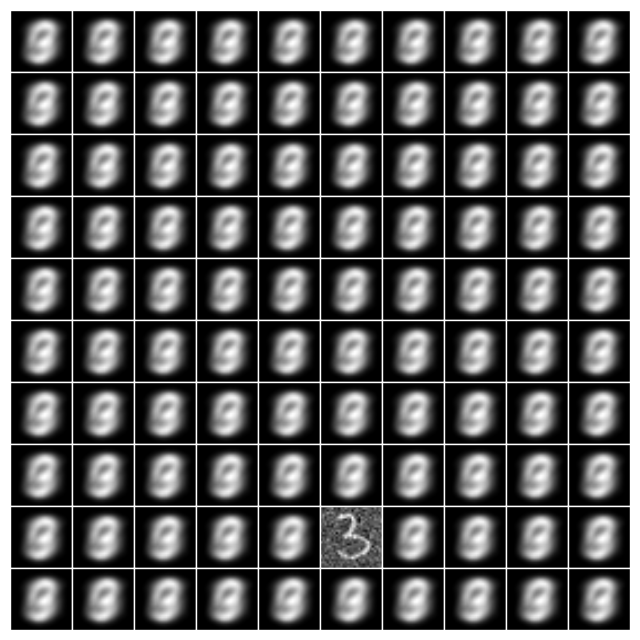

In [9]:
df = [rbm_nn.weights[1:, i].reshape(28, 28) for i in range(rbm_nn.n_hidden)]
plot_filters(df, 10, 10)

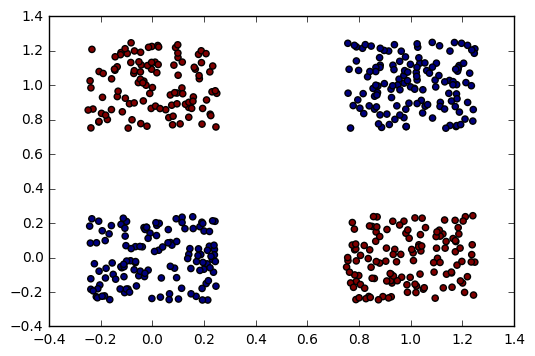

In [5]:
size_Train = 500
XOR_original = np.array(np.random.randint(0,2, size = (size_Train,2)), dtype='float')
y_xor_train = np.array([int(n[0] != n[1]) for n in XOR_original])
y_xor_train = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_train])
XOR_original += (np.random.random_sample((size_Train, 2)) - 0.5)*0.5

size_test = 250
XOR_test = np.array(np.random.randint(0,2, size = (size_test,2)), dtype='float')
y_xor_test = np.array([int(n[0] != n[1]) for n in XOR_test])
y_xor_test = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_test])
XOR_test += (np.random.random_sample((size_test, 2)) - 0.5)*0.5
plt.scatter(XOR_original[:,0], XOR_original[:,1], c=np.argmax(y_xor_train, axis = 1))

In [6]:
rbm_xor_nn = RBM(n_hidden=4, learning_rate=0.1, n_iter=10000, batch_size = 10)

In [7]:
rbm_xor_nn.fit(XOR_original)


from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# fitting
XOR_train_sampled = []
for idx, sample in enumerate(XOR_original):
    XOR_train_sampled.append(rbm_xor_nn.run_on_visible(sample.reshape(1,2)))

XOR_train_sampled = np.array(XOR_train_sampled).reshape(size_Train, rbm_xor_nn.n_hidden)

lr.fit(XOR_train_sampled, np.array([np.argmax(i) for i in y_xor_train]))

# predicting
XOR_test_sampled = []
for idx, sample in enumerate(XOR_test):
    XOR_test_sampled.append(rbm_xor_nn.run_on_visible(sample.reshape(1,2)))

XOR_test_sampled = np.array(XOR_test_sampled).reshape(size_test, rbm_xor_nn.n_hidden)

# true_pred = 0
# for idx, sample in enumerate(XOR_test_sampled):
#     if np.argmax(lr.predict_proba(sample.reshape(1,-1))) == np.argmax(y_xor_test[idx]):
#         true_pred += 1
# print "Accuracy: ", true_pred,'/',len(y_xor_test),'', 100*true_pred / float(len(y_xor_test)), '%'

# XOR

In [14]:
import nn

In [50]:
mlp_nn = nn.mlp_NN(batch_size=50, learning_rate=lambda x: 1.5, n_iter=1500,loss='cross-entropy',penalty='L1',C=1e-2,
               layers=[('Sigmoid', 4, True),
                       ('Softmax', 2, True)])

In [51]:
mlp_nn.fit(XOR_original, y_xor_train, init_weight=rbm_xor_nn.weights[1:,1:])

In [52]:
print 'Weights from RBM:'
print rbm_xor_nn.weights[1:,1:]
print 'Weights after BP:'
print mlp_nn.weights[0]

Weights from RBM:
[[  1.22560063  12.73656876   4.49973266 -12.49477105]
 [-25.87543981 -11.60053902  11.23751851 -12.11783975]]
Weights after BP:
[[  8.27940948  15.59153098   4.62849826  -8.67208111]
 [-24.18502835  -7.27230164  10.13590671  -9.6584135 ]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f68646e2d10>,
 <matplotlib.collections.PathCollection at 0x7f686455df10>)

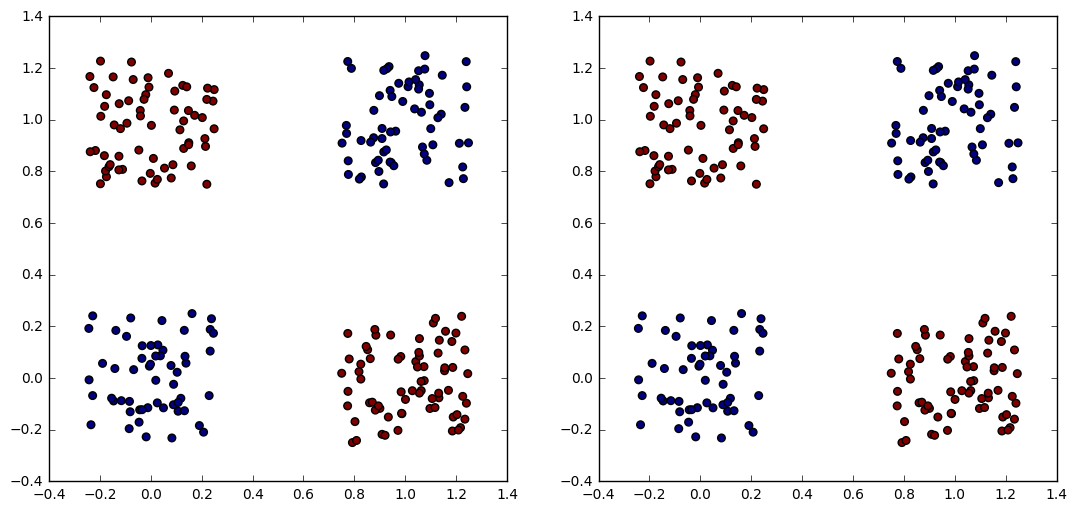

In [58]:
plt.subplots(1, 2, sharey=True, figsize=(13, 6))
plt.subplot(1,2,1),plt.scatter(XOR_test[:, 0], XOR_test[:, 1], c=np.argmax(y_xor_test, axis = 1), s=30)
plt.subplot(1,2,2),plt.scatter(XOR_test[:, 0], XOR_test[:, 1], c=np.argmax(mlp_nn.predict(XOR_test), axis = 1), s=30)